### optimised algorithms for change point detection (v3) 

#### Python package ruptures 

#### simulation using simulated data, gridsearch for optimal parameters

author: peter

date: 2024

Ruptures: 

C. Truong, L. Oudre, N. Vayatis. Selective review of offline change point detection methods. Signal Processing, 167:107299, 2020.

<li> https://centre-borelli.github.io/ruptures-docs/
<li> https://github.com/deepcharles/ruptures
<li> https://centre-borelli.github.io/ruptures-docs/user-guide/detection/
<li> see also https://schuetzgroup.github.io/sdt-python/changepoint.html

<br><br>

Algorithms: Binseg, Pelt, Window, Dynp, KernelCPD, BottomUp

Cost functions: (TO DO: add linear)<br>
mdl_list =['l1', 'l2', 'normal', 'rbf', 'cosine', 'clinear', 'rank', 'mahalanobis', 'ar']
<br>
#### simulation 
for each algorithm:<br>
&nbsp; set_seed(12345)<br>
&nbsp; for each trial:<br>
&nbsp; &nbsp; &nbsp; generate a new simulated dataset<br>
&nbsp; &nbsp; &nbsp; for each cost_function in cost_function_set:<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; test algorithm<br>
<br>
evaluate performance according to metrics<br>
generate report

<br><br>
metrics to compare algorithm performance:
<li>percent too early
<li>percent too late
<li>bias
<li>MAE
<li>variance
<li>FDR

In [9]:
import matplotlib.pylab as plt
import ruptures as rpt
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

### set simulation parameters

In [10]:
# set simulation parameters
#
my_rand_seed = 12345

margin=10   # margin of error for false discovery rate (fdr): FP/(TP+FP)
            # when detection is too late, e.g. > 10ms after true onset time

num_signals = 1000  # number of trials in simulation

mu, sigma = 0, 3 # mean and standard deviation for simulated data generation
mu2, sigma2 = mu + 1, sigma + 1

n_bkps=1
true_onset=200

times = np.arange(0, 451, 1).tolist()

# A new Pelt algorithm object must created for each trial.
# This might also be true for other algorithm implementations.
# Negligible performance hit, so no need to optimise.

# some algs can't use 'linear' cost function, not enough dimensions.
mdl_list =['l1', 'l2', 'normal', 'rbf', 'cosine', 'clinear', 'rank', 'mahalanobis', 'ar']

### simulated data generation
Every algorithm - parameter set will process the same random set of signals.

In [11]:
def make_data(mu, sigma, mu2, sigma2, true_onset, rng):
    s1 = rng.normal(mu, sigma, true_onset-1)
    s2 = rng.normal(mu2, sigma2, 251)
    signal= np.array(list(s1) + list(s2))
    return signal

### Binseg
https://dev.ipol.im/~truong/ruptures-docs/build/html/_modules/ruptures/detection/binseg.html <br>

algorithm defaults: model='l2', custom_cost=None, min_size=2, jump=5, params=None

In [ ]:
binseg_list = []

for mdl in mdl_list:
    binseg_predictions = []
    rng = np.random.default_rng(my_rand_seed)  
    
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
    
        # Binseg algorithm
        algo = rpt.Binseg(model=mdl, custom_cost=None, min_size=2, jump=5, params=None).fit(signal)
        est_onset = algo.predict(n_bkps=n_bkps)
        binseg_predictions.append(est_onset[0])
    binseg_list.append(binseg_predictions)

### Pelt
https://dev.ipol.im/~truong/ruptures-docs/build/html/detection/pelt.html<br>
<br>
algorithm defaults: model='l2', custom_cost=None, min_size=2, jump=5, params=None

In [13]:

pelt_list = []

for mdl in mdl_list:
    pelt_predictions = []
    rng = np.random.default_rng(my_rand_seed)
    
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
        
        # Pelt algorithm
        algo = rpt.Pelt(model=mdl, custom_cost=None, min_size=2, jump=5, params=None).fit(signal)
        est_onset = algo.predict(pen=2)           # penalty 1 --> early, 10 --> late
        pelt_predictions.append(est_onset[0])
    pelt_list.append(pelt_predictions)

### Window sliding segmentation
https://dev.ipol.im/~truong/ruptures-docs/build/html/detection/window.html<br>
<br>
algorithm defaults: width=100, model='l2', custom_cost=None, min_size=2, jump=5, params=None

In [14]:

window_list = []

for mdl in mdl_list:
    window_predictions = []
    rng = np.random.default_rng(my_rand_seed)
    
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
        
        # window algorithm
        algo = rpt.Window(width=100, model=mdl, custom_cost=None, min_size=2, jump=5).fit(signal)
        est_onset = algo.predict(n_bkps=n_bkps)
        window_predictions.append(est_onset[0])
    window_list.append(window_predictions)

### Dynamic Programming
https://dev.ipol.im/~truong/ruptures-docs/build/html/detection/dynp.html<br>
<br>
algorithm defaults: model='l2', custom_cost=None, min_size=2, jump=5, params=None

In [15]:
dp_list = []

for mdl in mdl_list:
    dp_predictions = []
    rng = np.random.default_rng(my_rand_seed)
    
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
        
        # Dynamic programming algorithm
        algo = rpt.Dynp(model=mdl, custom_cost=None, min_size=2, jump=5).fit(signal)
        est_onset = algo.predict(n_bkps=n_bkps)
        dp_predictions.append(est_onset[0])
    dp_list.append(dp_predictions)

##### KernelCPD
Efficient kernel change point detection<br>
Available kernels: linear, rbf, cosine <br>
<br>
algorithm defaults: kernel='linear', min_size=2, jump=5, params=None

In [16]:
kernelCPD_list = []

kernel_mdl_list = ['linear', 'rbf', 'cosine']

for mdl in kernel_mdl_list:
    kernel_predictions = []
    rng = np.random.default_rng(my_rand_seed)
    
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
        
        # kernelCPD
        algo = rpt.KernelCPD(kernel=mdl, min_size=2, jump=5, params=None).fit(signal)  # fast, written in C
        est_onset = algo.predict(n_bkps=n_bkps)
        kernel_predictions.append(est_onset[0])
    kernelCPD_list.append(kernel_predictions)

### Bottom up
https://dev.ipol.im/~truong/ruptures-docs/build/html/detection/bottomup.html<br>
available models = l1, l2, rbf <br>
algorithm defaults: model='l2', custom_cost=None, min_size=2, jump=5, params=None <br>
predict defaults: n_bkps=None, pen=None, epsilon=None

In [17]:
bottomUp_list = []

bottomUp_mdl_list = ['l1', 'l2', 'rbf'] # dims must be > 1 to use linear

for mdl in bottomUp_mdl_list:
    bottomUp_predictions = []
    rng = np.random.default_rng(my_rand_seed)
    
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
        
        # BottomUp
        algo = rpt.BottomUp(model=mdl, custom_cost=None, min_size=2, jump=5, params=None).fit(signal)  # written in C
        est_onset = algo.predict(n_bkps=n_bkps, pen=None)
        bottomUp_predictions.append(est_onset[0])
    bottomUp_list.append(bottomUp_predictions)

### helper functions

In [19]:
def get_too_early(predictions, true_onset):
    too_early = predictions[predictions < true_onset]
    too_early = np.abs(too_early - true_onset)
    return too_early


def get_pct_too_early(predictions, true_onset):
    too_early = predictions[predictions < true_onset]
    pct_too_early = len(too_early)/len(predictions)
    return pct_too_early


def get_MAE(predictions, true_onset):
    MAE = np.mean(np.abs(predictions - true_onset))
    return MAE


def get_std(predictions, true_onset):
    std = np.std(predictions)
    return std

def get_variance(predictions, true_onset):
    var = np.var(predictions)
    return var

def get_fdr(predictions, true_onset, margin):
    errors = predictions - true_onset
    early_count = sum(errors < 0)      # FP
    late_count = sum(errors > margin)  # FP
    fdr = (early_count + late_count)/len(predictions)
    return fdr

def get_bias(predictions, true_onset):
    bias=np.mean(predictions) - true_onset
    return bias


# precision = TP/(TP + FP)
def get_precision(predictions, true_onset, margin):
    errors = predictions - true_onset
    early_count = sum(errors < 0)      # FP
    late_count = sum(errors > margin)  # FP
    precision = (len(predictions) - (early_count + late_count))/len(predictions)
    return precision


# Same as precision if one onset prediction for each 
# time series where each time series has one true onset.
# Not really any FNs by definition because FNs == FPs.
#
# recall = TP/(TP+FN)
def get_recall(predictions, margin):
    errors = predictions - true_onset
    early_count = sum(errors < 0)      # FP
    late_count = sum(errors > margin)  # FP
    recall = (len(predictions) - (early_count + late_count))/len(predictions)
    return recall

# F1 = 2 * (precision * recall) / (precision + recall). 
def get_f1(precision, recall):
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1

def plot_predictions(predictions, title):
    pass


### choose model index for plotting [0..8]
mdl_list =['l1', 'l2', 'normal', 'rbf', 'cosine', 'clinear', 'rank', 'mahalanobis', 'ar']

In [20]:
mdl_idx=3

### plot detection distribution for each algorithm

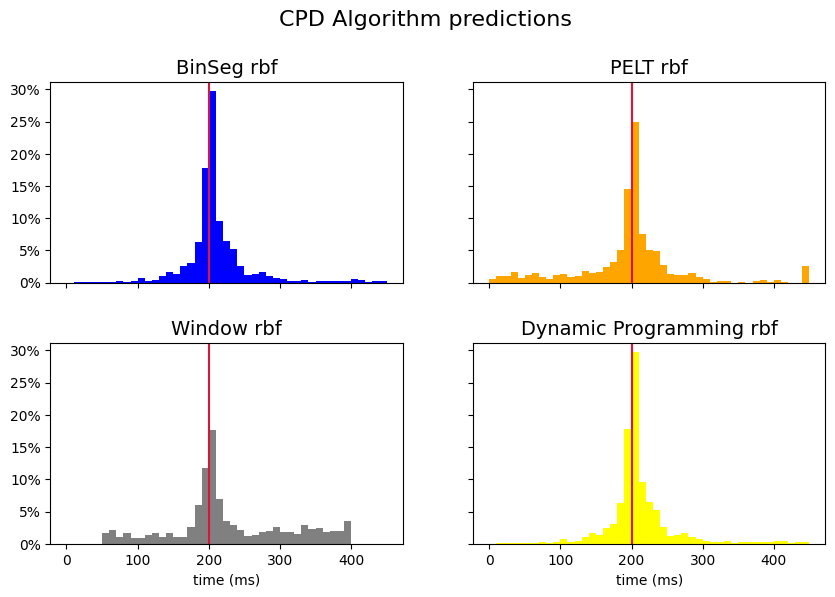

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('CPD Algorithm predictions', y=1, fontsize=16)

fig.set_figwidth(10)
fig.set_figheight(6)

plt.subplots_adjust(hspace = 0.3)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,  decimals=0))

binwidth=10
bins = np.linspace(0, 450, 46)
mdl  = mdl_list[mdl_idx]

preds=binseg_list[mdl_idx]
ax1.hist(preds, color='blue', bins=bins,  weights=np.ones(len(preds)) / len(preds))
ax1.set_title(("BinSeg %s" % mdl), fontsize=14)
ax1.axvline(200, c="crimson", label="real onset")

preds=pelt_list[mdl_idx]
ax2.hist(preds, color='orange', bins=bins,  weights=np.ones(len(preds)) / len(preds))
ax2.set_title(("PELT %s" % mdl), fontsize=14)
ax2.axvline(200, c="crimson", label="real onset")

preds=window_list[mdl_idx]
ax3.hist(preds, color='gray', bins=bins,  weights=np.ones(len(preds)) / len(preds))
ax3.set_title(("Window %s" % mdl), fontsize=14)
ax3.set_xlabel("time (ms)")
ax3.axvline(200, c="crimson", label="real onset")

preds = dp_list[mdl_idx]
ax4.hist(preds, color='yellow', bins=bins,  weights=np.ones(len(preds)) / len(preds))
ax4.set_title( ("Dynamic Programming %s" % mdl), fontsize=14)
ax4.set_xlabel("time (ms)")
ax4.axvline(200, c="crimson", label="real onset")

for ax in fig.get_axes():
    ax.label_outer()

### plot distribution of predictions for each algorithm as in (Sassenhagen and Draschkow, 2019)

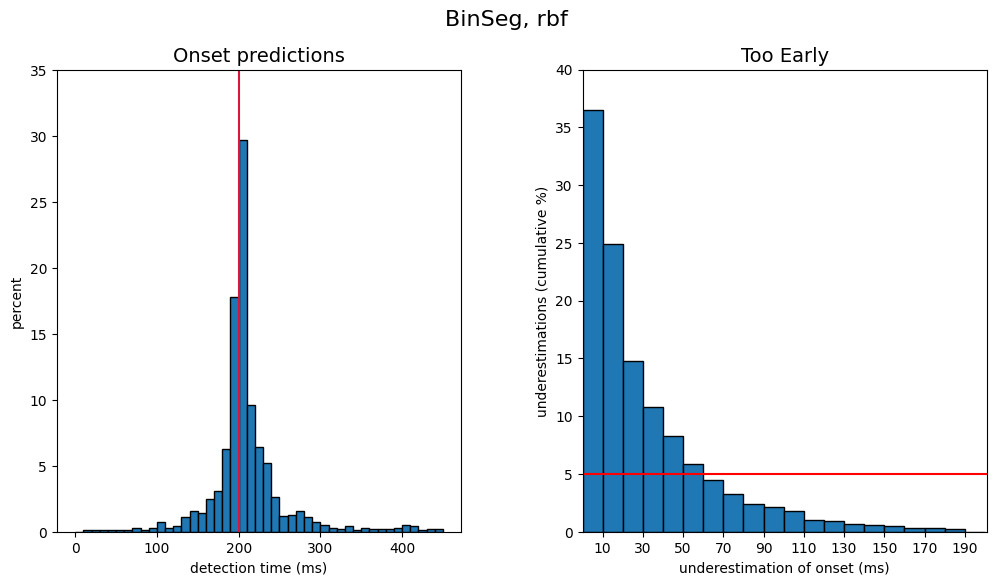

In [23]:
fig, [ax1, ax2] = plt.subplots(ncols=2)
fig.set_figwidth(12)
fig.set_figheight(6)

mdl=mdl_list[mdl_idx]
plt.suptitle( ("BinSeg, %s" % mdl), fontsize=16)

# 10 ms time steps, 10ms bin width
binwidth=10
bins = np.linspace(0, 450, 46)
predictions=binseg_list[mdl_idx]

ax1.hist(predictions,  edgecolor='black', bins=bins,  weights=np.ones(len(predictions)) / len(predictions))
ax1.set_title(("Onset predictions"), fontsize=14)
ax1.axvline(200, c="crimson", label="real onset")
ticks=ax1.get_yticks()
ax1.set_yticks(ticks)
ticks=ticks*100
ticks = [int(v)for v in ticks]
ax1.set_yticklabels(ticks);
ax1.set_xlabel("detection time (ms)")
ax1.set_ylabel("percent")

plt.subplots_adjust(wspace = 0.3)
total_predictions = len(predictions) # total number of predictions (predictions)

ax2.axhline(0.05, c="r", label="nominal 5% level")
ax2.set_ylabel("underestimations (cumulative %)")
ax2.set_xlabel("underestimation of onset (ms)")
ax2.set_xlim([0, 201])
ax2.set_xticks(range(10,201,20))

# this works better than sns histplot, etc, for reverse cumsum histogram
bin_width=10
bin_list = list(range(0, 201, bin_width))
too_early = [] 

for data_point in predictions:
    if data_point < true_onset:
        data_point = abs(data_point - true_onset) 
        too_early.append(data_point)

plt.hist(too_early, edgecolor='black', align="mid", cumulative=-1, bins=bin_list, weights=np.ones(len(too_early)) / total_predictions)
ax2.set_title(("Too Early"), fontsize=14)
ticks=ax2.get_yticks()
ax2.set_yticks(ticks)
ticks=ticks*100
ticks = [int(v)for v in ticks]
ax2.set_yticklabels(ticks);

### Report performance
<li>mean absolute error (MAE)
<li>variance (var)
<li>bias
<li>false discovery rate (fdr)

In [24]:
def report_performance(prediction_lists, mdl_list, algo_name):
    min_idx=0
    min_MAE=1000000
    pred_mae_list=[]
    for ii, preds in enumerate(prediction_lists):
        mdl = mdl_list[ii]
        preds = np.array(preds)
        MAE = get_MAE(preds, true_onset); 
        pred_mae_list.append(MAE)
        if MAE < min_MAE:
            min_MAE = MAE
            min_idx=ii
        var = get_variance(preds, true_onset)
        bias = get_bias(preds, true_onset)
        fdr = get_fdr(preds, true_onset, margin)
        print("%11s %11s: MAE = %6.2f ms, var=%8.2f, bias=%6.2f, fdr=%6.2f" % (algo_name, mdl, MAE, var, bias, fdr))
    print("Lowest MAE: %0.2f, cost function = %s" % (min_MAE, mdl_list[min_idx] )  )
    return pred_mae_list

In [25]:

algo_name="BinSeg"
binseg_mae_list=report_performance(binseg_list, mdl_list, algo_name)
print("\n")
algo_name="Pelt"
pelt_mae_list = report_performance(pelt_list, mdl_list, algo_name)
print("\n")
algo_name="Window"
window_mae_list = report_performance(window_list, mdl_list, algo_name)
print("\n")
algo_name="Dynamic Programming"
dp_mae_list = report_performance(dp_list, mdl_list, algo_name)
print("\n")
algo_name="KernelCPD"
kernel_mae_list = report_performance(kernelCPD_list, kernel_mdl_list, algo_name)
print("\n")
algo_name="BottomUp"
bottomUp_mae_list = report_performance(bottomUp_list, bottomUp_mdl_list, algo_name)
print("\n")

     BinSeg          l1: MAE =  67.54 ms, var= 8969.24, bias= 26.23, fdr=  0.84
     BinSeg          l2: MAE =  54.42 ms, var= 6658.02, bias= 25.75, fdr=  0.77
     BinSeg      normal: MAE =  14.29 ms, var=  697.12, bias=  1.31, fdr=  0.54
     BinSeg         rbf: MAE =  26.31 ms, var= 2222.35, bias=  7.46, fdr=  0.65
     BinSeg      cosine: MAE =  79.15 ms, var=11536.98, bias= 11.33, fdr=  0.89
     BinSeg     clinear: MAE = 194.32 ms, var=36681.43, bias= 54.87, fdr=  1.00
     BinSeg        rank: MAE =  51.63 ms, var= 6188.73, bias= 17.37, fdr=  0.79
     BinSeg mahalanobis: MAE =  54.42 ms, var= 6658.02, bias= 25.75, fdr=  0.77
     BinSeg          ar: MAE =  91.41 ms, var=12183.93, bias= 51.65, fdr=  0.86
Lowest MAE: 14.29, cost function = normal


       Pelt          l1: MAE = 183.59 ms, var=  237.82, bias=-183.59, fdr=  1.00
       Pelt          l2: MAE = 192.21 ms, var=   23.21, bias=-192.21, fdr=  1.00
       Pelt      normal: MAE = 188.41 ms, var=  103.17, bias=-188.41, fdr=

### make table using latex

In [27]:
headers = mdl_list
data = dict()
data["Binseg"]   = binseg_mae_list
data["Pelt"]     = pelt_mae_list
data["Window"]   = window_mae_list
data["Dyn Prog"] = dp_mae_list
#data["KernelCPD"] = kernel_mae_list
#data["BottonUp"]  = bottomUp_mae_list

textabular = f"l|{'r'*len(headers)}"
texheader = " & " + " & ".join(headers) + "\\\\"
texdata = "\\hline\n"
for label in data:
    texdata += f"{label} & {' & '.join(map(str, data[label]))} \\\\\n"
    if label == "BottomUp":
        texdata += "\\hline\n"

print("\\begin{table}")
print("\\caption{Mean Absolute Error (MAE)}")
print("\label{mae-table}")
print("\\begin{tabular}{"+textabular+"}")
print(texheader)
print(texdata, end="")
print("\\end{tabular}")
print("\\end{table}")


\begin{table}
\caption{Mean Absolute Error (MAE)}
\label{mae-table}
\begin{tabular}{l|rrrrrrrrr}
 & l1 & l2 & normal & rbf & cosine & clinear & rank & mahalanobis & ar\\
\hline
Binseg & 67.54 & 54.425 & 14.285 & 26.31 & 79.15 & 194.32 & 51.635 & 54.425 & 91.41 \\
Pelt & 183.585 & 192.205 & 188.41 & 44.715 & 131.665 & 191.48 & 147.08 & 126.965 & 193.665 \\
Window & 75.915 & 72.03 & 40.19 & 61.405 & 88.93 & 101.43 & 69.675 & 72.03 & 93.485 \\
Dyn Prog & 67.49 & 54.425 & 14.285 & 26.31 & 79.0 & 194.32 & 51.635 & 54.425 & 91.41 \\
\end{tabular}
\end{table}
